# Deep Learning Course: Lab Exercises

In this lab exercise you will:

a) Learn about Generative Adversarial Networks to generate fake images of MNIST digits.

b) Implement Generator and Discriminator networks

c) Learn training and evaluating a GAN.

d) Learn about mode collapse (hard to achieve intentionally, occurs when you don't want)

e) Try out DCGAN on your own



In [ ]:
### Connect to Google Drive if you are using Drive.

In [ ]:
### Import all your libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
## load train, test and validation label arrays
##here put your custom destination folder
# *****START CODE

bs = 100     # batch size
device = 0   # GPU device 


# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

# *****END CODE

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
## Generator and Discriminator networks

class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [ ]:
## build network

z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)
print(mnist_dim)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


784


In [ ]:
## Print networks

print(G)
print(D)

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:

# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [ ]:
## Define Generator and Discriminator training loop


def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(x.shape[0], z_dim).to(device))
    y = Variable(torch.ones(x.shape[0], 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()


def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(x.shape[0], 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on face
    z = Variable(torch.randn(x.shape[0], z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(x.shape[0], 1).to(device))

    D_output = D(x_fake.detach())
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [ ]:
# Train Generator and Discriminator networks

n_epoch = 10
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/10]: loss_d: 0.989, loss_g: 2.528
[2/10]: loss_d: 1.149, loss_g: 1.797
[3/10]: loss_d: 0.958, loss_g: 1.662
[4/10]: loss_d: 0.868, loss_g: 1.913
[5/10]: loss_d: 0.567, loss_g: 2.535
[6/10]: loss_d: 0.637, loss_g: 2.136
[7/10]: loss_d: 0.705, loss_g: 2.151
[8/10]: loss_d: 0.701, loss_g: 1.989
[9/10]: loss_d: 0.694, loss_g: 2.044
[10/10]: loss_d: 0.704, loss_g: 2.117


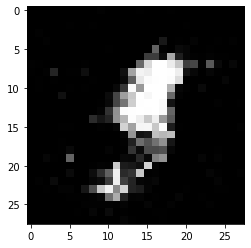

In [ ]:
with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)
    generated = generated.view(generated.size(0), 1, 28, 28)
    generated = generated.data.cpu().numpy()
    plt.imshow(generated[45][0], cmap="gray")

# DCGAN 

1) Create your own Generator or Discriminator convolutional network or

2) Google DCGAN networks and copy the Generator and Discriminator network

3) Modify training loops from Linear GAN to make it work for DCGAN networks 

4) Ask for help, if you get stuck



In [ ]:
### DCGAN

class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
      super(Generator, self).__init__()
      self.network = nn.Sequential(
          nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
          nn.BatchNorm2d(ngf*4),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 1, bias=False),
          nn.BatchNorm2d(ngf*2),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
          nn.Tanh()
      )
  
    def forward(self, x):
        x = x.unsqueeze(2).unsqueeze(3)
        output = self.network(x)
        return output

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
                
                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
            )
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1)

In [ ]:
## Define networks, loss function and optimizer

nc = 1            # 1 for grayscale and 3 for RGB
z_dim = 100       # noise vector size
ngf = 32          # number of features in Generator network
ndf = 32          # number of features in Discriminator network 
d_lr = 0.0002     # Discriminator learning rate
g_lr = 0.0002     # Generator learning rate 
batch_size = 256  # batch size
num_epochs = 100  # epochs

# Define Discriminator and Generator architectures
G = Generator(nc, z_dim, ngf).to(device)
D = Discriminator(nc, ndf).to(device)

# loss function
criterion = nn.BCELoss()

# optimizers
D_optimizer = optim.Adam(D.parameters(), lr=d_lr)
G_optimizer = optim.Adam(G.parameters(), lr=g_lr)


In [ ]:
## Define Generator and Discriminator training loop


def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()


def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x, torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake.detach())
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [ ]:
# Train Generator and Discriminator networks

for epoch in range(1, num_epochs+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), num_epochs, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/10]: loss_d: 0.067, loss_g: 5.369
[2/10]: loss_d: 0.022, loss_g: 6.694
[3/10]: loss_d: 0.015, loss_g: 7.441
[4/10]: loss_d: 0.039, loss_g: 7.091
[5/10]: loss_d: 0.034, loss_g: 6.567
[6/10]: loss_d: 0.097, loss_g: 5.510
[7/10]: loss_d: 0.219, loss_g: 4.131
[8/10]: loss_d: 0.274, loss_g: 3.371
[9/10]: loss_d: 0.379, loss_g: 3.080
[10/10]: loss_d: 0.411, loss_g: 2.726
[11/10]: loss_d: 0.392, loss_g: 2.578
[12/10]: loss_d: 0.404, loss_g: 2.623
[13/10]: loss_d: 0.430, loss_g: 2.527
[14/10]: loss_d: 0.434, loss_g: 2.417
[15/10]: loss_d: 0.432, loss_g: 2.451
[16/10]: loss_d: 0.463, loss_g: 2.491
[17/10]: loss_d: 0.447, loss_g: 2.427
[18/10]: loss_d: 0.451, loss_g: 2.458
[19/10]: loss_d: 0.454, loss_g: 2.461
[20/10]: loss_d: 0.445, loss_g: 2.413
[21/10]: loss_d: 0.445, loss_g: 2.476
[22/10]: loss_d: 0.426, loss_g: 2.490
[23/10]: loss_d: 0.417, loss_g: 2.558
[24/10]: loss_d: 0.425, loss_g: 2.516
[25/10]: loss_d: 0.450, loss_g: 2.547
[26/10]: loss_d: 0.407, loss_g: 2.486
[27/10]: loss_d: 0.42

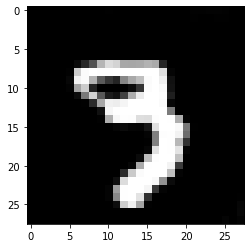

In [ ]:
with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)
    generated = generated.data.cpu().numpy()
    plt.imshow(generated[0][0], cmap="gray")